In [156]:
import numpy as np
from hmmlearn import hmm
from hmmlearn.base import ConvergenceMonitor
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colormaps
from static_probabilities import TRANSITION_PROBABILITIES_12UL, EMISSION_PROBABILITIES_12UL, START_PROBABILITIES_12UL
from time import time

In [2]:
from requests import get as _get

BASE_URL = 'http://localhost:8080'


def get(url: str) -> list:
    l = _get(f'{BASE_URL}/{url}').json()
    print(l[0])
    print(f'Fetched {len(l)} items')
    return l

In [3]:
detections = sorted(get('detection'), key=lambda x: x["timestamp"])

{'id': 479017, 'batonId': 15, 'stationId': 9, 'rssi': -95, 'battery': 92.0, 'uptimeMs': 554087, 'remoteId': 1, 'timestamp': 1650975012000}
Fetched 2401946 items


In [4]:
batons = get('baton')

{'id': 2, 'name': 'O', 'mac': '5a:45:55:53:00:00'}
Fetched 22 items


In [5]:
baton_switchovers = sorted(get('batonswitchover'), key=lambda x: x["timestamp"])

{'id': 1, 'teamId': 1, 'previousBatonId': None, 'newBatonId': 23, 'timestamp': 1651012254359}
Fetched 73 items


In [6]:
stations = get('station')

{'id': 2, 'name': 'station 1', 'distanceFromStart': 11.0, 'isBroken': False, 'url': 'http://172.12.50.101:8000'}
Fetched 7 items


In [7]:
teams = get('team')

{'id': 1, 'name': 'HILOK', 'batonId': 18}
Fetched 17 items


In [89]:
laps = get('accepted-laps')

{'id': 5096, 'teamId': 7, 'lapSourceId': 1, 'timestamp': 1651039200000}
Fetched 11294 items


In [8]:
team_detections: dict[int, list] = {team["id"]: [] for team in teams}
team_by_id: dict[int, dict] = {team["id"]: team for team in teams}
baton_team: dict[int, dict] = {}

switchover_index = 0
for detection in detections:
    while switchover_index < len(baton_switchovers) and baton_switchovers[switchover_index]["timestamp"] < detection[
        "timestamp"]:
        switchover = baton_switchovers[switchover_index]
        baton_team[switchover["newBatonId"]] = team_by_id[switchover["teamId"]]
        switchover_index += 1

    if detection["batonId"] in baton_team:
        if detection["rssi"] > -75:
            current_detections = team_detections[baton_team[detection["batonId"]]["id"]]
            if len(current_detections) > 0 and current_detections[-1]["timestamp"] == detection["timestamp"]:
                if current_detections[-1]["rssi"] < detection["rssi"]:
                    current_detections[-1] = detection
            else:
                current_detections.append(detection)

In [9]:
print({k: len(v) for k, v in team_detections.items()})

{1: 14615, 3: 10031, 4: 7088, 5: 12250, 8: 12208, 9: 8541, 10: 11384, 11: 9841, 12: 9495, 13: 9145, 14: 8939, 17: 5951, 7: 8614, 22: 8477, 6: 8803, 2: 8146, 16: 7698}


In [154]:
station_to_emission = {v: k for k, v in enumerate([station["id"] for station in stations])}
data = np.array([[station_to_emission[detection["stationId"]] for detection in team_detections[6]]])
transmat = np.array([
    [0.8, 0.1, 0., 0., 0., 0., 0.1],
    [0.1, 0.8, 0.1, 0., 0., 0., 0.],
    [0., 0.1, 0.8, 0.1, 0., 0., 0.],
    [0., 0., 0.1, 0.8, 0.1, 0., 0.],
    [0., 0., 0., 0.1, 0.8, 0.1, 0.],
    [0., 0., 0., 0., 0.1, 0.8, 0.1],
    [0.1, 0., 0., 0., 0., 0.1, 0.8]
])
emissionprob = np.array([
    [0.76, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04],
    [0.04, 0.76, 0.04, 0.04, 0.04, 0.04, 0.04],
    [0.04, 0.04, 0.76, 0.04, 0.04, 0.04, 0.04],
    [0.04, 0.04, 0.04, 0.76, 0.04, 0.04, 0.04],
    [0.04, 0.04, 0.04, 0.04, 0.76, 0.04, 0.04],
    [0.04, 0.04, 0.04, 0.04, 0.04, 0.76, 0.04],
    [0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.76],
])

model = hmm.CategoricalHMM(n_components=7, n_iter=1000, init_params="cs")
model.transmat_ = transmat.copy()
model.emissionprob_ = emissionprob.copy()
model.monitor_ = ConvergenceMonitor(model.monitor_.tol, model.monitor_.n_iter, model.monitor_.verbose)

model.fit(data)
model.monitor_

ConvergenceMonitor(
    history=[-14381.571156660419, -9557.611927379477, -8846.141570847823, -8744.97901201526, -8716.406594526066, -8706.563716553976, -8702.39318141689, -8700.220619413501, -8698.765790665062, -8697.77862968221, -8697.241710541308, -8696.941449380616, -8696.739844967462, -8696.594837715937, -8696.490672903818, -8696.416632102113, -8696.3639842959, -8696.326055158708, -8696.298141472787, -8696.27709435498, -8696.260847513218, -8696.248041043991, -8696.237764922158, -8696.229396153123],
    iter=24,
    n_iter=1000,
    tol=0.01,
    verbose=False,
)

In [253]:
model.startprob_

array([0.00000000e+000, 0.00000000e+000, 1.49383360e-097, 1.00000000e+000,
       6.25797576e-022, 8.33325223e-143, 0.00000000e+000])

In [254]:
model.sample(30)

(array([[3],
        [3],
        [3],
        [4],
        [4],
        [4],
        [4],
        [5],
        [6],
        [6],
        [6],
        [6],
        [0],
        [1],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [3],
        [4],
        [5],
        [5],
        [5],
        [6],
        [6],
        [6],
        [0],
        [1]]),
 array([3, 3, 3, 4, 4, 4, 4, 5, 6, 6, 6, 6, 0, 1, 2, 2, 2, 2, 2, 2, 3, 4,
        5, 5, 5, 6, 6, 6, 0, 1]))

In [255]:
E, Z = model.sample(30)

for e, v in zip(E, Z):
    print(e, v)

[3] 3
[3] 3
[4] 4
[4] 4
[5] 5
[5] 5
[5] 5
[5] 5
[6] 6
[0] 0
[0] 0
[0] 0
[0] 0
[1] 1
[1] 1
[1] 1
[2] 2
[2] 2
[2] 2
[3] 3
[3] 3
[3] 4
[4] 4
[5] 5
[5] 5
[5] 5
[5] 5
[6] 6
[6] 6
[6] 6


In [11]:
model.decode(data)[1][:100]

array([3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3,
       3, 4, 5, 5, 5, 6, 6, 6, 0, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 5,
       6, 6, 6, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 5, 5, 6, 6, 0, 1,
       1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5, 5, 6, 6, 6, 0, 0, 1, 2, 2, 2, 3,
       3, 4, 4, 4, 4, 5, 5, 6, 6, 0, 0, 0])

In [159]:
station_to_emission = {v: k for k, v in enumerate([station["id"] for station in stations])}
data = [[[station_to_emission[detection["stationId"]]] for detection in team_detections[i]] for i in team_detections.keys()]
np_data = np.concatenate(data)
lengths = [len(x) for x in data]

transmat = np.array([
    [0.8, 0.1, 0., 0., 0., 0., 0.1],
    [0.1, 0.8, 0.1, 0., 0., 0., 0.],
    [0., 0.1, 0.8, 0.1, 0., 0., 0.],
    [0., 0., 0.1, 0.8, 0.1, 0., 0.],
    [0., 0., 0., 0.1, 0.8, 0.1, 0.],
    [0., 0., 0., 0., 0.1, 0.8, 0.1],
    [0.1, 0., 0., 0., 0., 0.1, 0.8]
])
emissionprob = np.array([
    [0.76, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04],
    [0.04, 0.76, 0.04, 0.04, 0.04, 0.04, 0.04],
    [0.04, 0.04, 0.76, 0.04, 0.04, 0.04, 0.04],
    [0.04, 0.04, 0.04, 0.76, 0.04, 0.04, 0.04],
    [0.04, 0.04, 0.04, 0.04, 0.76, 0.04, 0.04],
    [0.04, 0.04, 0.04, 0.04, 0.04, 0.76, 0.04],
    [0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.76],
])

model = hmm.CategoricalHMM(n_components=7, n_iter=1000, init_params="")
model.transmat_ = TRANSITION_PROBABILITIES_12UL.copy()
model.emissionprob_ = EMISSION_PROBABILITIES_12UL.copy()
model.startprob_ = START_PROBABILITIES_12UL.copy()
model.monitor_ = ConvergenceMonitor(model.monitor_.tol, model.monitor_.n_iter, model.monitor_.verbose)

model.fit(np_data, lengths)
model.monitor_

ConvergenceMonitor(
    history=[-232136.70896702813, -138009.67644161143, -132126.913323049, -131222.29412486602, -131017.06538385375, -130925.9844277607, -130874.14486179096, -130842.21890781652, -130821.5507100937, -130807.63749876767, -130797.91163705624, -130791.0340986938, -130786.23685776512, -130782.88667240019, -130780.53132250413, -130778.86785807053, -130777.69108897113, -130776.85770985585, -130776.26541662455, -130775.84183812175, -130775.53672691408, -130775.31541682433, -130775.15385840145, -130775.03520891674, -130774.94756706992, -130774.8824603065, -130774.83381885706, -130774.79727008137, -130774.76964772436, -130774.74864785635, -130774.73258615688, -130774.72022566372, -130774.71065367018],
    iter=33,
    n_iter=1000,
    tol=0.01,
    verbose=False,
)

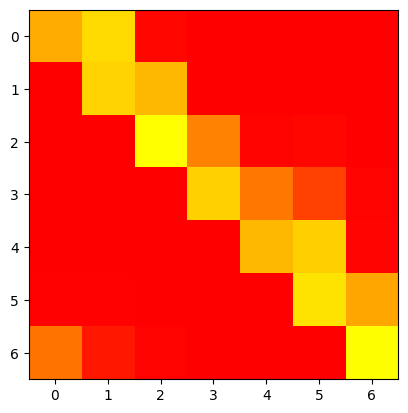

In [53]:
plt.imshow(model.transmat_, interpolation='none', cmap=colormaps["autumn"])
plt.show()

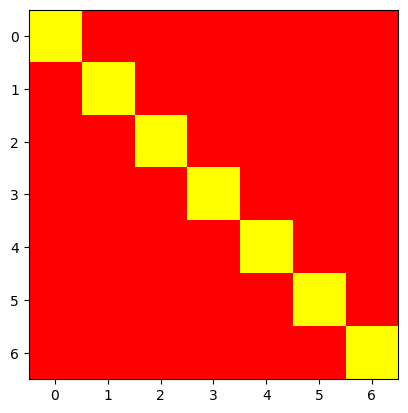

In [55]:
plt.imshow(model.emissionprob_, interpolation='none', cmap=colormaps["autumn"])
plt.show()

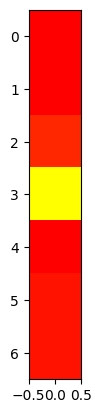

In [56]:
plt.imshow(np.array([model.startprob_]).reshape((7,1)), interpolation='none', cmap=colormaps["autumn"])
plt.show()

# Counting Laps

In [54]:
model.decode(np.array([[station_to_emission[detection["stationId"]] for detection in team_detections[1]]]))

(-10946.790256270811, array([3, 4, 4, ..., 6, 0, 6]))

In [160]:
start = time()

start_segment = list(model.startprob_).index(np.max(model.startprob_))
counts = []
half = 7/2

team_laps: dict[int, list[int]] = {}

for team in teams:
    _, path = model.decode(np.array([[station_to_emission[detection["stationId"]] for detection in team_detections[team["id"]]]]))
    count = 0
    prev = path[0]
    lap_times = []
    for i, segment in enumerate(path[1:]):
        delta = half - (half - (segment - prev)) % 7
        if delta > 0 and prev > segment:
            count += 1
            lap_times.append(team_detections[team["id"]][i+1]["timestamp"])
        elif delta < 0 and prev < segment:
            count -= 1
            lap_times.pop()
        prev = segment

    counts.append((team["name"], count))
    team_laps[team['id']] = lap_times

counts = sorted(counts, key=lambda x:x[1])

print(counts)
print(team_laps)

labels = [l for l, _ in counts]
counts = [c for _, c in counts]

print(f'Took: {time() - start}')

[('Antilopen', 522), ('Lila - VDK', 542), ('Lombrosiana - VBK', 568), ('SK', 580), ('HILOK Ladies', 613), ('Blandinia', 618), ('VPPK', 621), ('VRG', 622), ('Politeia', 627), ('HK', 628), ('HERMES - GFK', 649), ('Wetenschappen', 662), ('VGK', 685), ('VEK - ML', 707), ('VLK', 764), ('VTK', 864), ('HILOK', 873)]
{1: [1651042825000, 1651042874000, 1651042920000, 1651042968000, 1651043016000, 1651043065000, 1651043116000, 1651043161000, 1651043215000, 1651043265000, 1651043316000, 1651043365000, 1651043411000, 1651043460000, 1651043511000, 1651043559000, 1651043611000, 1651043662000, 1651043711000, 1651043758000, 1651043812000, 1651043860000, 1651043910000, 1651043960000, 1651044011000, 1651044061000, 1651044108000, 1651044157000, 1651044208000, 1651044256000, 1651044307000, 1651044355000, 1651044404000, 1651044457000, 1651044508000, 1651044560000, 1651044613000, 1651044665000, 1651044717000, 1651044768000, 1651044820000, 1651044875000, 1651044926000, 1651044980000, 1651045031000, 165104507

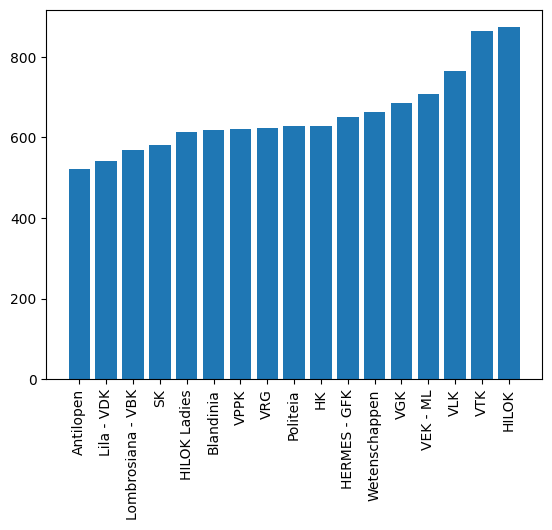

In [161]:
# Make a random dataset:
y_pos = np.arange(len(labels))

# Create bars
plt.bar(y_pos, counts)

# Create names on the x-axis
plt.xticks(y_pos, labels, rotation=90)

# Show graphic
plt.show()

# Static Parameters visualisation

In [67]:
model = hmm.CategoricalHMM(n_components=7, n_iter=1000, init_params="s")
model.transmat_ = TRANSITION_PROBABILITIES_12UL.copy()
model.emissionprob_ = EMISSION_PROBABILITIES_12UL.copy()
model.startprob_ = START_PROBABILITIES_12UL.copy()

model.score(np_data, lengths)

-232136.70896702813

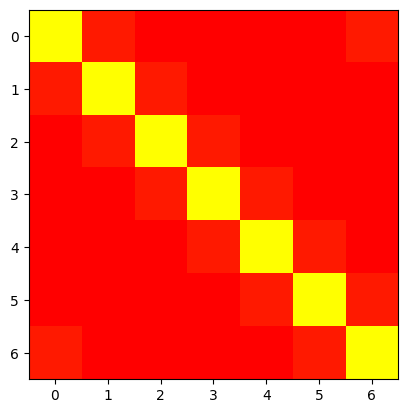

In [33]:
plt.imshow(model.transmat_, interpolation='none', cmap=colormaps["autumn"])
plt.show()

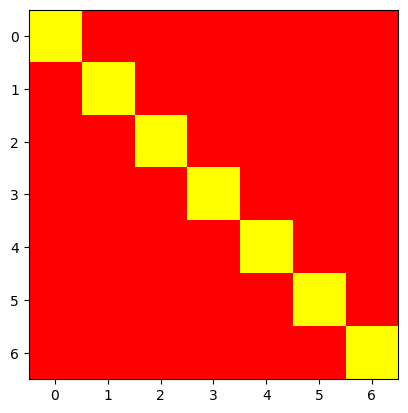

In [34]:
plt.imshow(model.emissionprob_, interpolation='none', cmap=colormaps["autumn"])
plt.show()

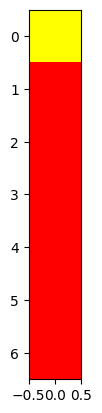

In [37]:
plt.imshow(np.array([model.startprob_]).reshape((7,1)), interpolation='none', cmap=colormaps["autumn"])
plt.show()

In [162]:
urenloop_count = [{"count": 875, "team": {"id": 1, "name": "HILOK"}}, {"count": 777, "team": {"id": 3, "name": "VLK"}}, {"count": 669, "team": {"id": 4, "name": "Wetenschappen"}}, {"count": 629, "team": {"id": 5, "name": "VRG"}}, {"count": 649, "team": {"id": 8, "name": "HERMES - GFK"}}, {"count": 553, "team": {"id": 9, "name": "Lila - VDK"}}, {"count": 626, "team": {"id": 10, "name": "VPPK"}}, {"count": 730, "team": {"id": 11, "name": "VEK - ML"}}, {"count": 631, "team": {"id": 12, "name": "HK"}}, {"count": 565, "team": {"id": 13, "name": "Lombrosiana - VBK"}}, {"count": 622, "team": {"id": 14, "name": "Blandinia"}}, {"count": 528, "team": {"id": 17, "name": "Antilopen"}}, {"count": 642, "team": {"id": 7, "name": "Politeia"}}, {"count": 613, "team": {"id": 22, "name": "HILOK Ladies"}}, {"count": 740, "team": {"id": 6, "name": "VGK"}}, {"count": 868, "team": {"id": 2, "name": "VTK"}}, {"count": 577, "team": {"id": 16, "name": "SK"}}]

# eventual count with all sources addes
#urenloop_count = {entry["team"]["name"]: entry["count"] for entry in urenloop_count}

# Only viterbi count - without manual data
urenloop_count = {team["name"]: len([lap["timestamp"] for lap in laps if lap["teamId"] == team["id"] and lap["lapSourceId"] == 3]) for team in teams}

own_count = [('Antilopen', 522), ('Lila - VDK', 542), ('Lombrosiana - VBK', 568), ('SK', 580), ('HILOK Ladies', 613), ('Blandinia', 618), ('VPPK', 621), ('VRG', 622), ('Politeia', 627), ('HK', 628), ('HERMES - GFK', 649), ('Wetenschappen', 662), ('VGK', 685), ('VEK - ML', 707), ('VLK', 764), ('VTK', 864), ('HILOK', 873)]

own_count = {entry[0]: entry[1] for entry in own_count}

diff = {k: v-urenloop_count[k] for k, v in own_count.items()}
diff

{'Antilopen': 8,
 'Lila - VDK': -7,
 'Lombrosiana - VBK': 3,
 'SK': 3,
 'HILOK Ladies': 1,
 'Blandinia': -1,
 'VPPK': 5,
 'VRG': -3,
 'Politeia': -5,
 'HK': -1,
 'HERMES - GFK': 0,
 'Wetenschappen': 2,
 'VGK': -7,
 'VEK - ML': 10,
 'VLK': 3,
 'VTK': 4,
 'HILOK': -2}

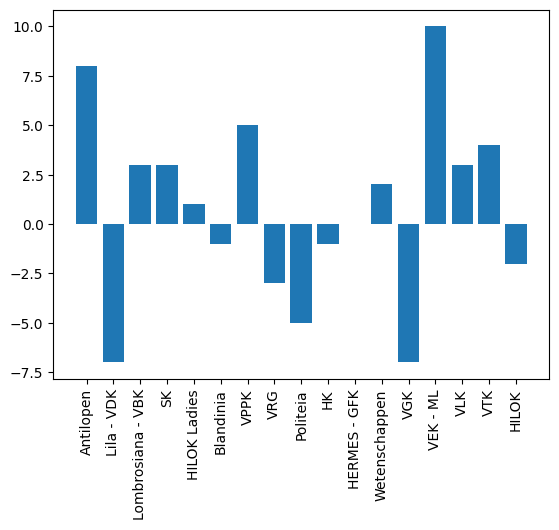

In [163]:
# Make a random dataset:
y_pos = np.arange(len(labels))

# Create bars
plt.bar(y_pos, diff.values())

# Create names on the x-axis
plt.xticks(y_pos, diff.keys(), rotation=90)

# Show graphic
plt.show()

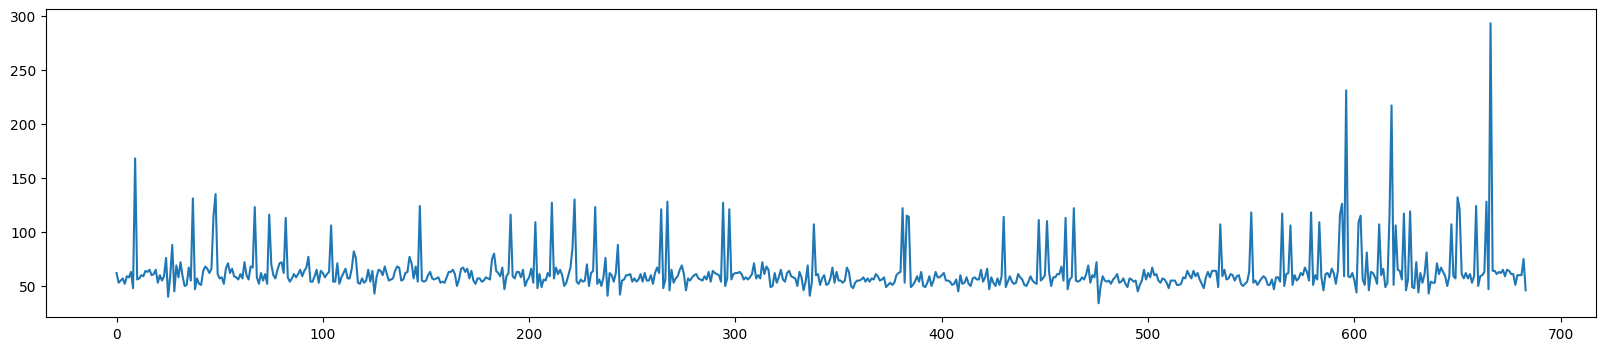

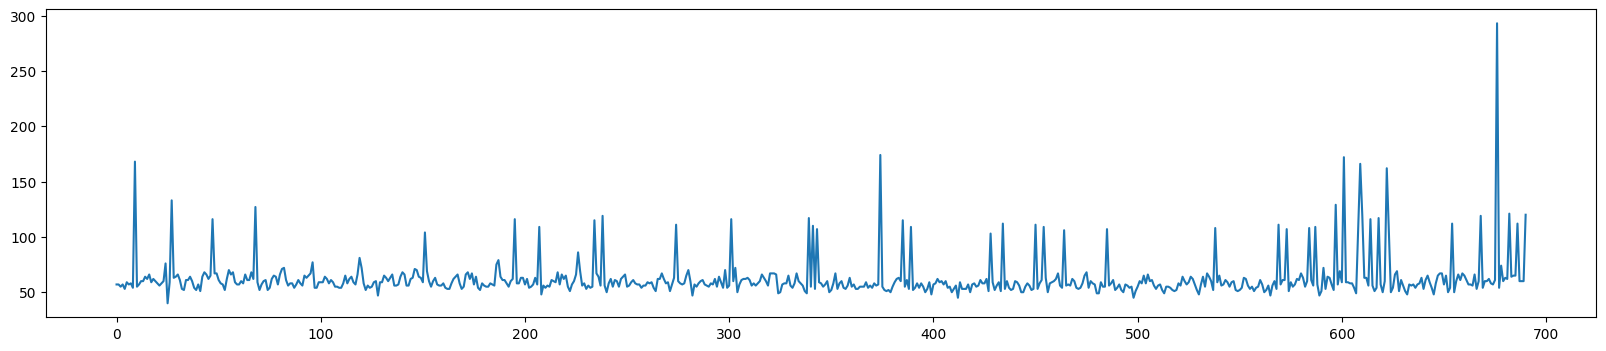

In [164]:
i = 6
relative_laptimes = []
prev = team_laps[i][0]
for time in team_laps[i][1:]:
    relative_laptimes.append((time-prev)/1000)
    prev = time

plt.figure(figsize=(20, 4))
plt.plot(np.array(relative_laptimes))
plt.show()

lapss = [lap["timestamp"] for lap in laps if lap["teamId"] == i and lap["lapSourceId"] == 3]

relative_laptimes = []
prev = lapss[0]
for time in lapss[1:]:
    relative_laptimes.append((time-prev)/1000)
    prev = time

plt.figure(figsize=(20, 4))
plt.plot(np.array(relative_laptimes))
plt.show()

In [109]:
print(len([lap["timestamp"] for lap in laps if lap["teamId"] == 6 and lap["lapSourceId"] == 1]))

48


In [131]:
print(len([lap["timestamp"] for lap in laps if lap["teamId"] == 6 and lap["lapSourceId"] == 3]))

692


In [132]:
teams

[{'id': 1, 'name': 'HILOK', 'batonId': 18},
 {'id': 3, 'name': 'VLK', 'batonId': 12},
 {'id': 4, 'name': 'Wetenschappen', 'batonId': 6},
 {'id': 5, 'name': 'VRG', 'batonId': 9},
 {'id': 8, 'name': 'HERMES - GFK', 'batonId': 10},
 {'id': 9, 'name': 'Lila - VDK', 'batonId': 21},
 {'id': 10, 'name': 'VPPK', 'batonId': 19},
 {'id': 11, 'name': 'VEK - ML', 'batonId': 7},
 {'id': 12, 'name': 'HK', 'batonId': 13},
 {'id': 13, 'name': 'Lombrosiana - VBK', 'batonId': 2},
 {'id': 14, 'name': 'Blandinia', 'batonId': 4},
 {'id': 17, 'name': 'Antilopen', 'batonId': 16},
 {'id': 7, 'name': 'Politeia', 'batonId': 3},
 {'id': 22, 'name': 'HILOK Ladies', 'batonId': 8},
 {'id': 6, 'name': 'VGK', 'batonId': 17},
 {'id': 2, 'name': 'VTK', 'batonId': 15},
 {'id': 16, 'name': 'SK', 'batonId': 22}]